In [1]:
import os
from os.path import join, exists, splitext, basename
from imp import reload
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

from pixyz.distributions import Normal, Bernoulli, Categorical, ProductOfNormal
from pixyz.losses import KullbackLeibler, CrossEntropy
from pixyz.models import Model, VAE


from models import *
from utils import *

from mnist_A_data_loader import get_mnist_A_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = get_mnist_A_loader("../data/MNIST_A/train_X/",
                                  "../data/MNIST_A/train_y.npy")
test_loader = get_mnist_A_loader("../data/MNIST_A/test_X/", 
                                 "../data/MNIST_A/test_y.npy")
valid_loader = get_mnist_A_loader("../data/MNIST_A/valid_X/", 
                                  "../data/MNIST_A/valid_y.npy")

log_dir = "./logs"
classifier = MNIST_A_Classifier().to(device)
classifier.load_state_dict(torch.load(join(log_dir, 'MNIST_A_classifier.pkl')))
classifier.eval()

cuda


MNIST_A_Classifier(
  (conv_e): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc_e): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [2]:
z_dim = 2

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="p_prior")

# encoder
q_y1 = Encoder_Y1().to(device)
q_y2 = Encoder_Y2().to(device)
q_y = ProductOfNormal([q_y1, q_y2])

q = Encoder_XY().to(device)
q_x = Encoder_X().to(device)

# decoder
p_x = Decoder_X().to(device)
p_y1 = Decoder_Y1().to(device)
p_y2 = Decoder_Y2().to(device)

p = p_x * p_y1 * p_y2
print(p)


kl = KullbackLeibler(q, prior)
kl_x = KullbackLeibler(q, q_x)
kl_y = KullbackLeibler(q, q_y)

regularizer = kl + kl_x + kl_y
print(regularizer)

model = VAE(q, p, other_distributions=[q_x, q_y],
            regularizer=regularizer, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

experiment_name =  'JMVAE_expert_MNIST_A_z_dim{}'.format(z_dim)

Distribution:
  p(x,y1,y2|z) = p(x|z)p(y1|z)p(y2|z)
Network architecture:
  p(y2|z) (Bernoulli): Decoder_Y2(
    (fc_d): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  p(y1|z) (Bernoulli): Decoder_Y1(
    (fc_d): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  p(x|z) (Bernoulli): Decoder_X(
    (fc_d): Sequential(
      (0): Linear(in_features=2, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in

# train

In [ ]:
for i in range(10):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = label2onehot(y)
        y = y.to(device)
        loss = model.train({"x": x, "y1": y[:, :1], "y2": y[:, 1:]})
 
    print("train")
    encoder_plot(train_loader, q_x, p_x, conditional=False)
    print("valid")
    encoder_plot(valid_loader, q_x, p_x, conditional=False)


torch.save(p_x.state_dict(), join(log_dir, 'px_{}.pkl'.format(experiment_name)))
torch.save(p_y1.state_dict(), join(log_dir, 'py1_{}.pkl'.format(experiment_name)))
torch.save(p_y2.state_dict(), join(log_dir, 'py2_{}.pkl'.format(experiment_name)))
torch.save(q_x.state_dict(), join(log_dir, 'qx_{}.pkl'.format(experiment_name)))
torch.save(q_y1.state_dict(), join(log_dir, 'qy1_{}.pkl'.format(experiment_name)))
torch.save(q_y2.state_dict(), join(log_dir, 'qy2_{}.pkl'.format(experiment_name)))
torch.save(q.state_dict(), join(log_dir, 'q_{}.pkl'.format(experiment_name)))

# 検証

## y→z, z→x

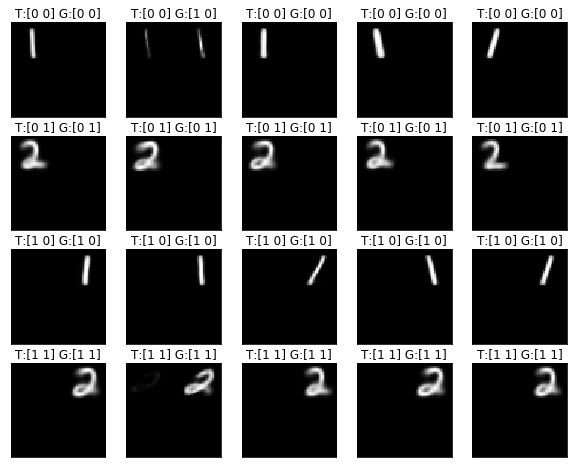

In [3]:
p_x.load_state_dict(torch.load(join(log_dir, 'px_{}.pkl'.format(experiment_name))))
q_x.load_state_dict(torch.load(join(log_dir, 'qx_{}.pkl'.format(experiment_name))))
q_y1.load_state_dict(torch.load(join(log_dir, 'qy1_{}.pkl'.format(experiment_name))))
q_y2.load_state_dict(torch.load(join(log_dir, 'qy2_{}.pkl'.format(experiment_name))))
p_y1.load_state_dict(torch.load(join(log_dir, 'py1_{}.pkl'.format(experiment_name))))
p_y2.load_state_dict(torch.load(join(log_dir, 'py2_{}.pkl'.format(experiment_name))))
q.load_state_dict(torch.load(join(log_dir, 'q_{}.pkl'.format(experiment_name))))


p_y = p_y1*p_y2
q_y = ProductOfNormal([q_y1, q_y2])
p_x.eval()
q_y.eval()
p_y.eval()

sample_size = 5
label_num = 4
labels = []
for i in range(2):
    for j in range(2):
        for k in range(sample_size):
            labels.append([i, j])

labels = torch.FloatTensor(labels).to(device)

torch.random.manual_seed(42)
z = q_y.sample({"y1": labels[:, :1], "y2": labels[:, 1:]})["z"]
samples = p_x.sample_mean({"z": z})
pred_y = classifier(samples) > 0.5


pred_y = pred_y.detach().cpu().numpy()
labels = labels.detach().cpu().numpy().astype(int)
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*2, label_num*2))
for i in range(sample_size*label_num):
    plt.subplot(label_num, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("T:{} G:{}".format(labels[i], pred_y[i]))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()

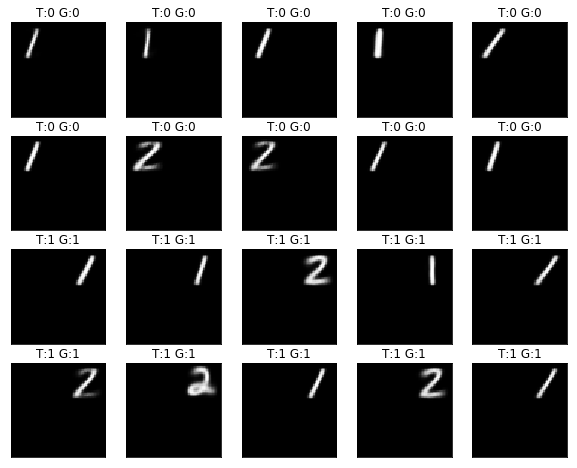

In [4]:
sample_size = 5
label_num = 4
labels = []
for i in range(2):
    for j in range(2):
        for k in range(sample_size):
            labels.append([i, j])

labels = torch.FloatTensor(labels).to(device)

torch.random.manual_seed(42)
z = q_y.sample({"y1": labels[:, :1]})["z"]
samples = p_x.sample_mean({"z": z})
pred_y = classifier(samples) > 0.5


pred_y = pred_y.detach().cpu().numpy()
labels = labels.detach().cpu().numpy().astype(int)
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*2, label_num*2))
for i in range(sample_size*label_num):
    plt.subplot(label_num, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("T:{} G:{}".format(labels[i][0], pred_y[i][0]))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()

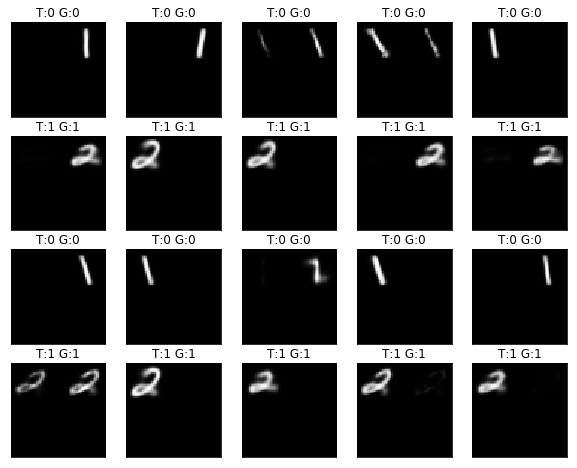

In [5]:
sample_size = 5
label_num = 4
labels = []
for i in range(2):
    for j in range(2):
        for k in range(sample_size):
            labels.append([i, j])

labels = torch.FloatTensor(labels).to(device)

torch.random.manual_seed(42)
z = q_y.sample({"y2": labels[:, 1:]})["z"]
samples = p_x.sample_mean({"z": z})
pred_y = classifier(samples) > 0.5


pred_y = pred_y.detach().cpu().numpy()
labels = labels.detach().cpu().numpy().astype(int)
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*2, label_num*2))
for i in range(sample_size*label_num):
    plt.subplot(label_num, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("T:{} G:{}".format(labels[i][1], pred_y[i][1]))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()

## y → z

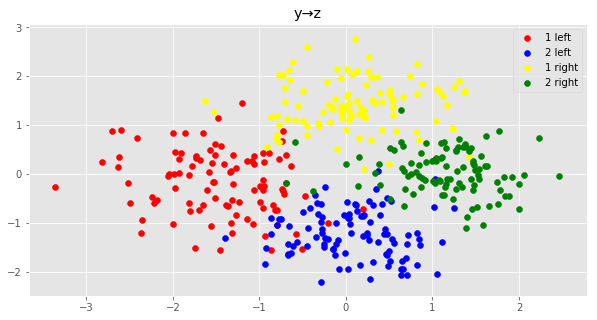

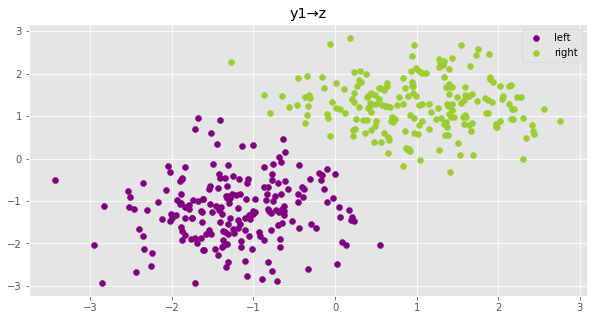

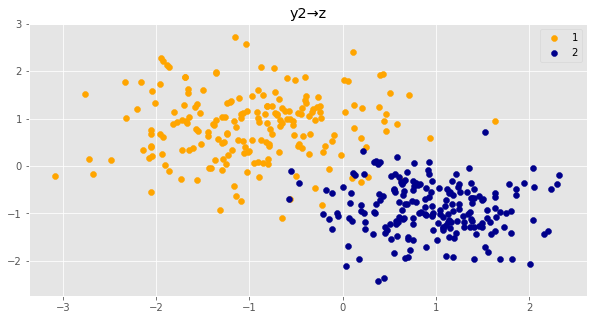

In [6]:
pos_x_list = [0, 36]
pos_y_list = [0]
angle_list = [0]
scale_list = [28] 
unique_label = []
for m in [1, 2]:
    for k2, pos_y in enumerate(pos_y_list):
        for k1, pos_x in enumerate(pos_x_list):
            for j, angle in enumerate(angle_list):
                theta = np.pi * angle/180
                sin = np.sin(theta).round(3)
                cos = np.cos(theta).round(3)
                for i, scale in enumerate(scale_list):
                    unique_label.append([scale, sin, cos, pos_x, pos_y, m])
unique_label = np.array(unique_label)


plt.style.use("ggplot")
sample_size = 100
label_num = 4
labels = []
for i in range(2):
    for j in range(2):
        for k in range(sample_size):
            labels.append([i, j])

labels = torch.FloatTensor(labels).to(device)

torch.random.manual_seed(42)
z = q_y.sample({"y1": labels[:, :1], "y2": labels[:, 1:]})["z"]
labels = labels.detach().cpu().int().numpy()
z = z.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
colors = np.array(
    [['red','blue'], 
     ['yellow','green']])
label = np.array(
    [['1 left','2 left'], 
     ['1 right','2 right']])
for i in range(2):
    for j in range(2):
        mask = (labels == [i, j]).sum(1) == 2
        plt.scatter(z[mask][:, 0], z[mask][:, 1], c=colors[i][j], label=label[i][j])
plt.legend()
plt.title("y→z")
plt.show()


labels = torch.FloatTensor(labels).to(device)
z = q_y.sample({"y1": labels[:, :1]})["z"]
labels = labels.detach().cpu().int().numpy()
z = z.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
colors = np.array(['purple','yellowgreen'])
label = np.array(['left','right'])
for i in range(2):
    mask = (labels[:, :1] == i).sum(1) == 1
    plt.scatter(z[mask][:, 0], z[mask][:, 1], c=colors[i], label=label[i])
plt.legend()
plt.title("y1→z")
plt.show()

labels = torch.FloatTensor(labels).to(device)
z = q_y.sample({"y2": labels[:, 1:]})["z"]
labels = labels.detach().cpu().int().numpy()
z = z.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
colors = np.array(['orange','darkblue'])
label = np.array(['1','2'])
for i in range(2):
    mask = (labels[:, 1:] == i).sum(1) == 1
    plt.scatter(z[mask][:, 0], z[mask][:, 1], c=colors[i], label=label[i])
plt.legend()
plt.title("y2→z")
plt.show()


## x→z

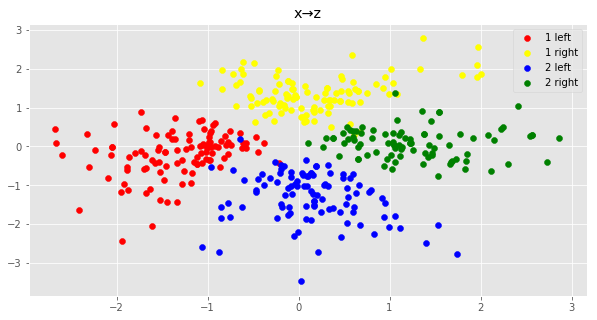

In [7]:
test_loader_all = get_mnist_A_loader("../data/MNIST_A/test_X/",
                                 "../data/MNIST_A/test_y.npy", [], batch_size=400)

x_all, y_all = iter(test_loader_all).next()
y_all_np = y_all.numpy().copy()

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
colors = np.array(['red', 'yellow','blue','green'])
label = np.array(['1 left','1 right','2 left','2 right'])
for i in range(4):
    mask = (y_all_np == unique_label[i]).sum(1) == 6
    x = x_all.to(device)
    z = q_x.sample_mean({"x": x})
    z = z.detach().cpu().numpy()
    plt.scatter(z[mask][:, 0], z[mask][:, 1], c=colors[i], label=label[i])
plt.legend()
plt.title("x→z")
plt.show()

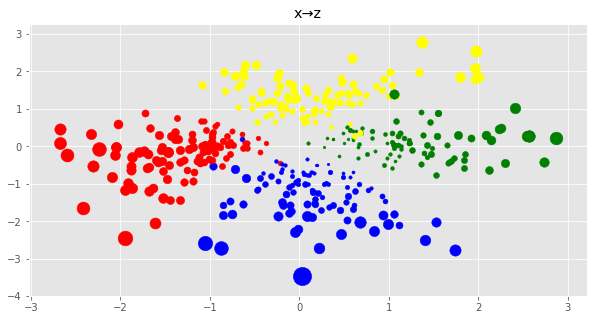

In [8]:
z = q_x(x)
z_loc = z["loc"].detach().cpu().numpy()
z_scale = z["scale"]
scale_norm = (z_scale.norm(dim=1)**2 * 1000).detach().cpu().numpy()
plt.figure(figsize=(10, 5))
for i in range(400):
    c = ((y_all_np[i] == unique_label).sum(1) == 6).argmax()
    plt.scatter(z_loc[i, 0], z_loc[i, 1], c=colors[c], s=scale_norm[i])
plt.title("x→z")
plt.show()

## xy→z

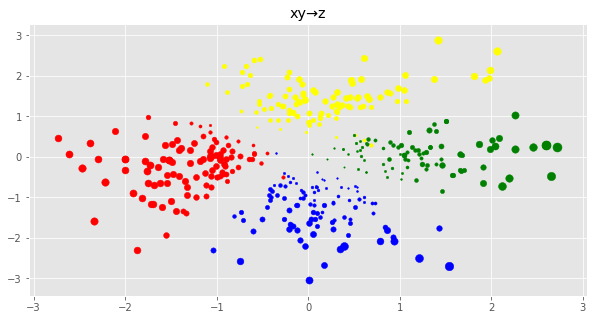

In [9]:
y = label2onehot(y_all).to(device)
z = q(x, y[:, :1], y[:, 1:])
z_loc = z["loc"].detach().cpu().numpy()
z_scale = z["scale"]
scale_norm = (z_scale.norm(dim=1)**2 * 1000).detach().cpu().numpy()
plt.figure(figsize=(10, 5))
for i in range(400):
    c = ((y_all_np[i] == unique_label).sum(1) == 6).argmax()
    plt.scatter(z_loc[i, 0], z_loc[i, 1], c=colors[c], s=scale_norm[i])
plt.title("xy→z")
plt.show()

## z→y

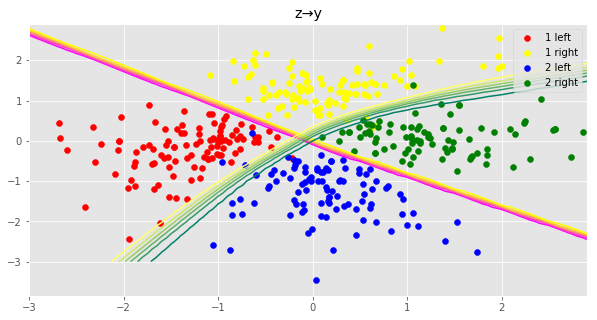

In [10]:
x_ = np.arange(-3, 3, 0.1) # x軸
y_ = np.arange(-3, 3, 0.1) # y軸
 
X, Y = np.meshgrid(x_, y_)
X_ = X.reshape(-1)[:, None]
Y_ = Y.reshape(-1)[:, None]
XY = torch.cat([torch.FloatTensor(X_), torch.FloatTensor(Y_)], dim=1)
pos_prob = p_y1(torch.FloatTensor(XY).to(device))["probs"].detach().cpu().numpy()
label_prob = p_y2(torch.FloatTensor(XY).to(device))["probs"].detach().cpu().numpy()
Z_pos = pos_prob.reshape(-1, 60)
Z_label = label_prob.reshape(-1, 60)

plt.figure(figsize=(10, 5))
plt.contour(X, Y, Z_pos, cmap=plt.cm.spring)
plt.contour(X, Y, Z_label, cmap=plt.cm.summer_r)

colors = np.array(['red', 'yellow','blue','green'])
label = np.array(['1 left','1 right','2 left','2 right'])
for i in range(4):
    mask = (y_all_np == unique_label[i]).sum(1) == 6
    x = x_all.to(device)
    z = q_x.sample_mean({"x": x})
    z = z.detach().cpu().numpy()
    plt.scatter(z[mask][:, 0], z[mask][:, 1], c=colors[i], label=label[i])
plt.legend()
plt.title("z→y")
plt.show()